# US Census Dataset analysis

by Hugo Palmer, applying for a Data-scientist position @ Dataiku - hugo.palmer@polytechnique.org

To run this entire notebook, it takes about 2-3 minutes on my laptop. /!\ PYTHON 3.5

In [1]:
%matplotlib inline

Importation of libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1 - Load & format the data

I saved the code to load the data in the file data_loading.py . Basically, when calling the main function ld.load_data, we:
- load the train or test set
- put the column names at the proper places
- convert various ways of saying 'no data' ("Not in universe", "Not in universe or children"...) to the  standard NaN expression 
- create the decision variable 'high_income' (+/- 50K$)
- put the proper dtypes:
        * int64 when it is a continuous parameter
        * bool when it is a categorical parameter with exactly two outputs
        * object when it is a categorical parameter with more than two outputs

In [3]:
import data_loading as ld

In [4]:
data = ld.load_data('train')

In [5]:
data.dtypes

age                                            int64
class of worker                               object
detailed industry recode                      object
detailed occupation recode                    object
education                                     object
wage per hour                                  int64
enroll in edu inst last wk                    object
marital stat                                  object
major industry code                           object
major occupation code                         object
race                                          object
hispanic origin                               object
sex                                           object
member of a labor union                         bool
reason for unemployment                       object
full or part time employment stat             object
capital gains                                  int64
capital losses                                 int64
dividends from stocks                         

In [6]:
data.head(3)

,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,high_income
0,73,NaN,0,0,High school graduate,0,NaN,Widowed,NaN,NaN,...,United-States,United-States,United-States,Native- Born in the United States,0,True,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,NaN,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,True,2,52,94,- 50000.
2,18,NaN,0,0,10th grade,0,High school,Never married,NaN,NaN,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,True,2,0,95,- 50000.


The prediction will therefore be on the last column 'high_income', that is set to True when the income is greater than 50000$

# 2 - Analysis/audit of the different columns

## Missing values

For each column, we print the proportion of missing values

In [7]:
nb_lines = len(data.index)
for col in data.columns:
    if(data[col].dtype=='O'):
        print(np.round((data[col]=='NaN').sum() / nb_lines * 100, 1), "% of NaN in column", col)

50.2 % of NaN in column class of worker
0.0 % of NaN in column detailed industry recode
0.0 % of NaN in column detailed occupation recode
0.0 % of NaN in column education
93.7 % of NaN in column enroll in edu inst last wk
0.0 % of NaN in column marital stat
50.5 % of NaN in column major industry code
56.5 % of NaN in column major occupation code
1.8 % of NaN in column race
86.3 % of NaN in column hispanic origin
0.0 % of NaN in column sex
97.0 % of NaN in column reason for unemployment
0.0 % of NaN in column full or part time employment stat
37.6 % of NaN in column tax filer stat
92.1 % of NaN in column region of previous residence
92.4 % of NaN in column state of previous residence
0.0 % of NaN in column detailed household and family stat
0.0 % of NaN in column detailed household summary in household
50.9 % of NaN in column migration code-change in msa
50.7 % of NaN in column migration code-change in reg
50.7 % of NaN in column migration code-move within reg
72.3 % of NaN in column fa

Some columns lack a lot of data; some are intuitive like 'enroll in edu inst last wk' (most of people were not students last year) or 'reason for unemployment' (most of people are not unemployed, hopefully...). On the other hand , we notice that some columns were compulsory when being filled by agents (sex, citizenship, ...) because we do not witness any missing value.

For further analysis, we split the columns in numerical and categorical columns:

In [8]:
header_data = data.columns
numerical_columns = []
categorical_columns = []
for col in header_data:
    if data[col].dtype == 'int64':
        numerical_columns.append(col)
    else:
        categorical_columns.append(col)

In [9]:
print(numerical_columns)

['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 'num persons worked for employer', 'weeks worked in year']


### Numerical columns

We first work with the numerical (ie continuous) variables. First, we can use directly the .describe() function that gives us the mean, standard deviation, min, max and the quartiles.

In [10]:
np.round(data[numerical_columns].describe(),1) #we limit the display to 1 decimal to ease the reading

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
count,199523.0,199523.0,199523.0,199523.0,199523.0,199523.0,199523.0
mean,34.5,55.4,434.7,37.3,197.5,2.0,23.2
std,22.3,274.9,4697.5,271.9,1984.2,2.4,24.4
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,15.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,33.0,0.0,0.0,0.0,0.0,1.0,8.0
75%,50.0,0.0,0.0,0.0,0.0,4.0,52.0
max,90.0,9999.0,99999.0,4608.0,99999.0,6.0,52.0


We notice that most of those numeric columns are not balanced: 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks' have a 75% percentile set to 0, which means that most of the people have 0 in those columns. Obviously, 'age' is more balanced with a high standard deviation. We can plot histograms for those columns:

I selected some variables which admit different distributions, depending on wether the person has a high income or not:

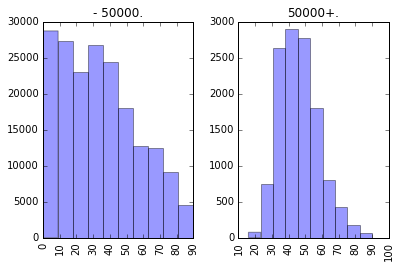

In [11]:
nice_display=data['age'].hist(xlabelsize=10, ylabelsize=10, by=data.high_income, alpha=0.4)

The age distribution of high-income people is much centered on the ages 30-60, which is coherent with the usual working age of citizens

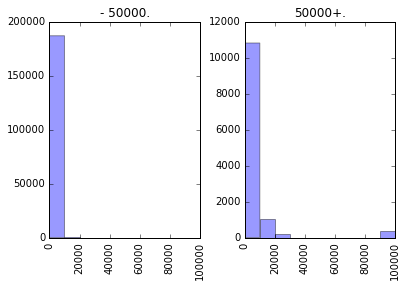

In [12]:
nice_display=data['capital gains'].hist(xlabelsize=10, ylabelsize=10, by=data.high_income, alpha=0.4)

The happy-few earning significant amounts of money thanks to capital are nearly all high-income.

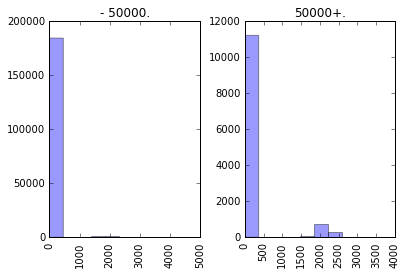

In [13]:
nice_display=data['capital losses'].hist(xlabelsize=10, ylabelsize=10, by=data.high_income, alpha=0.4)

Similarly, the people loosing a lot of money from capital are relatively often in the high income category. This may be explained by the fact that they have other revenues. ( high capital variation => still a high amount of capital => high income)

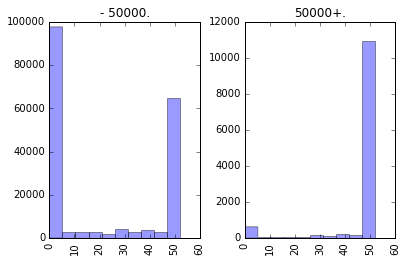

In [14]:
nice_display=data['weeks worked in year'].hist(xlabelsize=10, ylabelsize=10, by=data.high_income, alpha=0.4)

The two spikes observed in the 'weeks worked in year' means that most people work 0 or 52 weeks: part-time jobs are relatively seldom. Logically, high income people are full-time workers in majority.

We could similarly analyse the other numerical variables, but for the sake of conciseness we will now focus on categorical variables.

### Categorical columns

In [15]:
print(categorical_columns)

['class of worker', 'detailed industry recode', 'detailed occupation recode', 'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code', 'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union', 'reason for unemployment', 'full or part time employment stat', 'tax filer stat', 'region of previous residence', 'state of previous residence', 'detailed household and family stat', 'detailed household summary in household', 'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt', 'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self', 'citizenship', 'own business or self employed', "fill inc questionnaire for veteran's admin", 'veterans benefits', 'year', 'high_income']


We begin with a sad but clear observation: women are relatively much more seldom in the high-income category, even though there are more women in the data set. The mosaic plot is convenient to notice this:

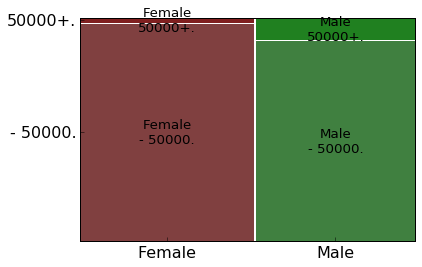

In [16]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 16.0
mosaic(data, ['sex', 'high_income']);

I have also plotted histograms for six categorical variables the proportion of each category for both low and high revenue groups.  

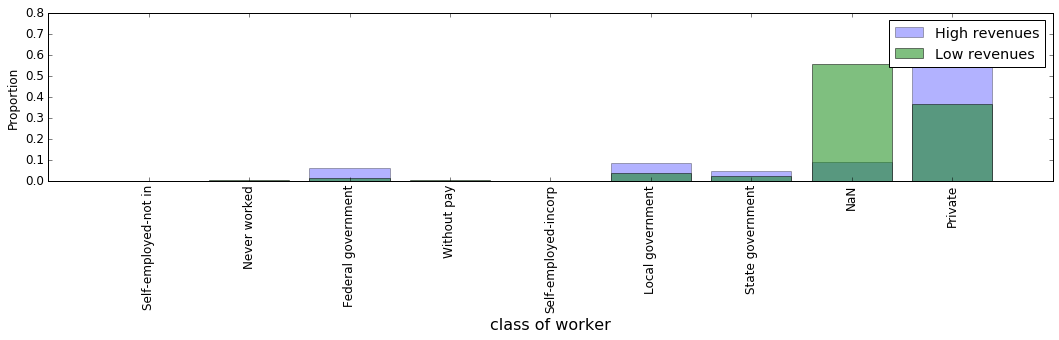

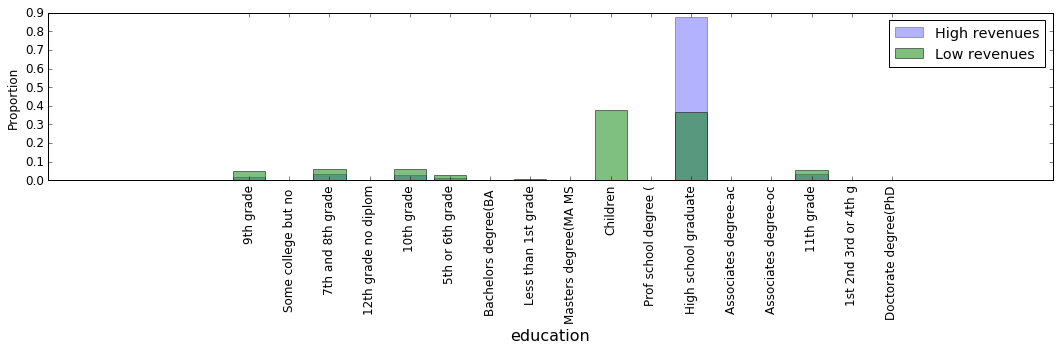

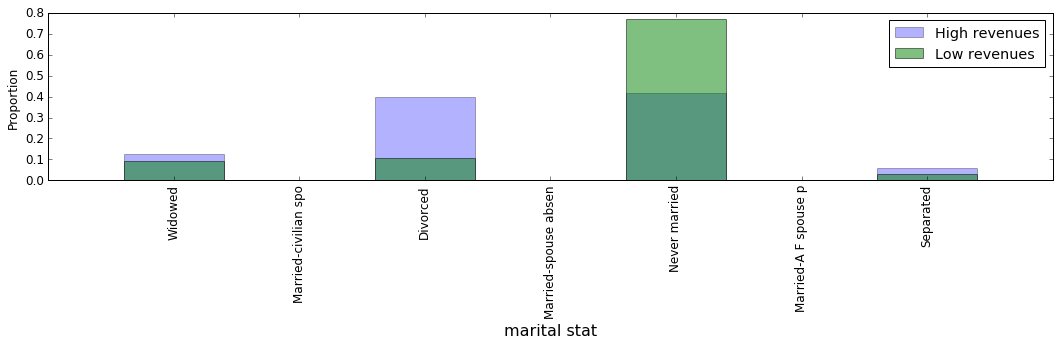

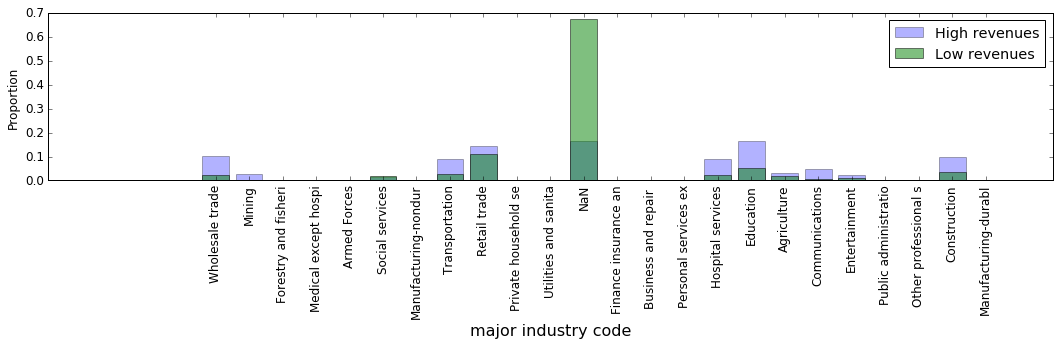

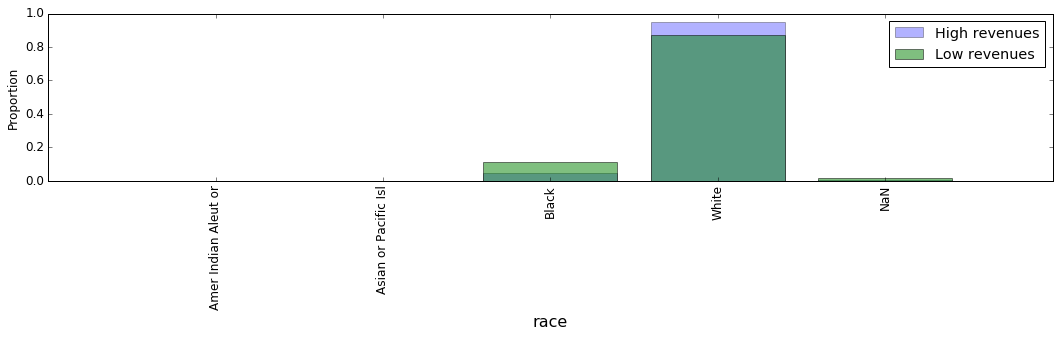

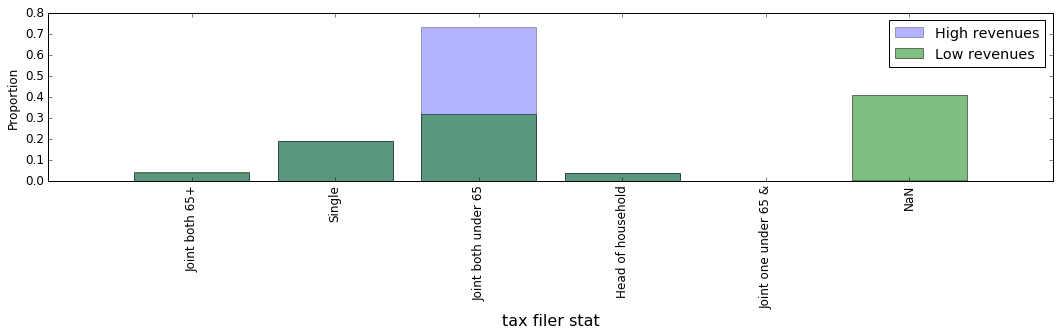

In [17]:
data_high_income = data[data['high_income']=='50000+.']
data_low_income  = data[data['high_income']=='- 50000.']
plt.rcParams['font.size'] = 12

categorical_columns_to_plot = ['class of worker', 'education', 'marital stat', 'major industry code', 'race', 'tax filer stat']

for col in categorical_columns_to_plot:
    # initializations
    fig = plt.figure(figsize=(18,3))
    ax = fig.add_subplot(111)
    values_col = sorted(list(map(ld.truncate, set(data[col]))))
    nb_values_col = np.zeros_like(values_col, dtype=float)
    dict_values = {}

    # plotting for high revenues
    for i in range(len(values_col)):
        nb_values_col[i] = len(data_high_income.loc[data_high_income[col]==values_col[i]].index)
    for i in range(len(values_col)):
        dict_values[values_col[i]] = nb_values_col[i]/nb_values_col.sum()
    plt.bar(range(len(dict_values)), dict_values.values(), align='center', color='blue', alpha=0.3)
    
    # plotting for low revenues
    for i in range(len(values_col)):
        nb_values_col[i] = len(data_low_income.loc[data_low_income[col]==values_col[i]].index)
    for i in range(len(values_col)):
        dict_values[values_col[i]] = nb_values_col[i]/nb_values_col.sum()
    plt.bar(range(len(dict_values)), dict_values.values(), align='center', color='green', alpha=0.5)
    
    ax.set_xlabel(col, fontsize=16)
    ax.set_ylabel("Proportion")
    ax.legend([plt.Rectangle((0, 0), 1, 1, fc="blue", alpha = 0.3),
                   plt.Rectangle((0, 0), 1, 1, fc="green", alpha = 0.5),],
                  ['High revenues', 'Low revenues'])

    plt.xticks(range(len(dict_values)), dict_values.keys(), rotation=90)

    plt.show()
    

# 2 - Models for prediction

In [18]:
data = ld.column_to_bool(data, "high_income", true_value='50000+.', false_value='- 50000.')

In [19]:
data_test = ld.load_data('test', high_income_as_bool=True)

## Creation of new variables

To predict which people win more or less than 50K$, we may consider new variables that would be combinations of the different columns and that would be intuitively correlated to people's earnings. We propose the variable capital_increase , which uses the variables about capital and dividends:

In [20]:
data['capital_increase'] = data['capital gains'] + data['capital losses'] + data['dividends from stocks']
data_test['capital_increase'] = data_test['capital gains'] + data_test['capital losses'] + data_test['dividends from stocks']

In [21]:
[data, data_test] = ld.normalize_continuous(data, data_test, numerical_columns)

## Binarization of categorical variables

When loading the data (cf file data_loading.py), we took care of the categorical variables that admitted only two values: we changed them to booleans. 
The other categorical variables, that admit more than two values, may be translated to binary variables to be taken into account easily by scikit-learn. We can use the pandas function get_dummies():

In [22]:
[X_tr, y_tr, X_te, y_te, column_names] = ld.get_train_test_sets(data, data_test)

Now, we have the training (X_tr, y_tr) and test (X_te, y_te) sets in the shape of integer numpy array. Therefore, they may be easily plugged in in scikit-learn ML algorithms:

In [23]:
X_tr

array([[ 0.81111111,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.64444444,  0.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.2       ,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       ..., 
       [ 0.52222222,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.17777778,  0.        ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 0.35555556,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

## Prediction

We stored the class 'Classification' in the file classification.py. We define the object classifier:

In [24]:
from classification import Classification

In [25]:
classifier = Classification(X_tr, y_tr, X_te, y_te)

In our classifier, the following algorithms may be used: 'randomforest', 'decisiontree', 'logreg':

In [26]:
classifier.prediction(classifier_name='logreg')

In [27]:
(classifier.y_pred == y_te ).sum()

95111

## How to measure the precision of prediction?

Most of the time, the accuracy is a good way to evaluate the performance of an binary classifier. Nevertheless, the two classes are unbalanced in our case: 94% vs 6%. In this case, the accuracy is a poor indicator of the performance. Indeed, the constant classifier (that predicts low income in all cases) would perform to 94%, while obviously being bad.

Therefore, we can consider other scores. Knowing the number of true positive (TP), true negative (TN), false positive (FP), false negative (FN), we have the following definitions:
- precision = TP/(TP+FP) = "fraction of retrieved instances that are relevant"
- recall = TP/(TP+FN) = "fraction of relevant instances that are retrieved"
- roc_auc (area under curve) = area under the precision/recall curve
- accuracy = (TP+TN)/(TP+TN+FP+FN)
- F1-score = harmonic mean of precision and recall

(source: wikipedia)

For unbalanced data, precision and recall are more relevant than accuracy. There exist several ways of quantifying the preference for precision vs. recall, and I find that roc_auc and the F1-score are interesting. (the 1 in F1 means that we consider as equally important precision and recall).

Therefore, we will evaluate the previous scoring methods with cross validation on the training set.

## Cross-validation

We implemented the .cross_validation() method that calls the cross-validation module of scikit-learn with the proper parameters. We can call it for the following classifiers: 'logreg', 'decisiontree', 'randomforest' ; the scoring methods can be any of sklearn.metrics.SCORERS ; we will limit our study to the 5 previously defined scorers. 

For example, we can do scikit-learn's default 3-fold cross validation for the Logistic regression to evaluate the precision. We display the average precision and check that the standard deviation is not too high.

In [28]:
# takes about 40 seconds to run
classifier.cross_validation(classifier_name='logreg', scoring_method='precision')

average  precision over three instances = 0.716770232858 ; standard deviation: 0.00782086081117
[ 0.71162992  0.72782164  0.71085914]


We stored the results for the three algorithms (Logistic regression, Random Forest, Decision Tree):

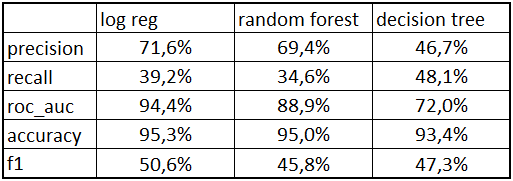

In [29]:
from IPython.display import Image
Image("results.png")

We observe that the decision tree provides a better recall than both logreg and random forest. Therefore, if we were only interested in identifying the highest number of high-revenue people (without taking care of increasing the number of False Positive by a lot), decision tree could be an interesting choice.

In terms of roc_auc and F1 (that are the most relevant as we have explained above), we notice that the Logistic regression significantly outperforms random forest and decision tree. Having seen those results and without more information on the goal of our previsions, it makes no doubt to me that the best trade-off is to choose logistic regression among those three algorithms.

## Quantifying the importance of features

In [30]:
classifier.prediction(classifier_name='logreg')

In [31]:
coefs_logreg = classifier.classifier.coef_[0]
columns_sorted = column_names[np.argsort(coefs_logreg)][::-1]
coefs_columns_sorted = coefs_logreg[np.argsort(coefs_logreg)][::-1]

We print the features by decreasing order of importance:

In [32]:
for i in range(20):
    print(columns_sorted[i], coefs_columns_sorted[i])

dividends from stocks 3.16201003729
age 2.80619030608
capital losses 2.04765441503
education_11th grade 2.00805376305
weeks worked in year 1.92806795437
education_Associates degree-occup /vocational 1.71448013742
detailed industry recode_28 1.42592555488
education_Bachelors degree(BA AB BS) 1.42402525636
country of birth self_Canada 1.32010561905
detailed industry recode_1 0.982261435
num persons worked for employer 0.973122431835
detailed household and family stat_Child <18 spouse of subfamily RP 0.929856640637
detailed occupation recode_20 0.927169165537
detailed occupation recode_7 0.887748310134
detailed industry recode_15 0.874283476965
state of previous residence_Minnesota 0.864053054289
education_Children 0.843486109318
detailed occupation recode_6 0.805117354961
detailed occupation recode_32 0.737100973053
state of previous residence_North Carolina 0.73380304174


Unsurprisingly, we find that the dividends from stock, capital losses and age variables are important in the decision. The level of education is also an important feature.

## Apply on the test set

Having chosen Logistic Regression thanks to cross-validation, we are now able to train a model and make effective prediction on the test set. 

In [33]:
import sklearn.metrics as metrics
classifier.prediction(classifier_name='logreg')
y_pred=classifier.y_pred

In [34]:
print("precision:", 100*np.round(metrics.precision_score(y_true=y_te, y_pred=y_pred), 4), "%")
print("recall:", 100*np.round(metrics.recall_score(y_true=y_te, y_pred=y_pred), 4), "%")
print("accuracy_score", 100*np.round(metrics.accuracy_score(y_true=y_te, y_pred=y_pred), 4), "%")
print("F1:", 100*np.round(metrics.f1_score(y_true=y_te, y_pred=y_pred), 4), "%")

precision: 73.14 %
recall: 39.22 %
accuracy_score 95.34 %
F1: 51.06 %


We notice that those valued are close to what noticed in the instances of cross-validation, which validates our model. As a bottomline, the recall is still quite low (only 39% of high revenues are identified), but the precision is good (73% of people labelled as high income by our model are effectively hgh income.

# Conclusion

I have really liked to conduct this study. I was not well aware of the distinctions between precision, recall, F1, etc... before and I find that this has been a good opportunity to learn this topic (because of the very unbalanced classes).
I have spent most of the time on plotting the graphs but I am happy to have done this because I feel much more comfortable in this field now.

I could have put more emphasis on the prediction (test other algorithms in particular), but I did not want to spend too much time on the work. Once again, a relatively simple algorithm seems to be the most performing, which is an interesting point I believe!